# Face Mask Detection and Social Distancing
<br>Table of Contents (Unfinished): 

* [Prerequisites](#1)
    * [Installing the Dependencies](#2)
    * [Loading the Dataset](#3)
* [Face detection and social distancing detection](#4)
    * [Using Haarcascades to Detect Faces](#5)


<a id="1"></a>
## Prerequisites

<a id="2"> </a>
### Installing the Dependencies

In [5]:
!pip install keras
!pip install tensorflow
!pip install scikit-learn
!pip install imutils
!pip install numpy
!pip install matplotlib
!pip install opencv-python
!pip install pillow

In [ ]:
# Keras imports
from tensorflow import keras


from keras.preprocessing.image import ImageDataGenerator
from keras.applications import MobileNetV2
from keras.layers import AveragePooling2D, Dropout, Flatten, Dense, Input
from keras.models import Model
from keras.optimizers import Adam
from keras.applications.mobilenet_v2 import preprocess_input
# from keras.utils import img_to_array, load_img
from keras.utils import to_categorical

from keras.preprocessing.image import load_img, img_to_array
from PIL import Image


# # sklearn imports
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# # imutils imports
from imutils import paths

# # misc
import numpy as np # linear algebra
import matplotlib.pyplot as plt
import os
import cv2

from scipy.spatial import distance

import warnings
warnings.filterwarnings('ignore')

: 

<a id="3"> </a>
### Loading the Data Set

In [4]:
# Directory structure
# CS180-MASKPATROL    
# |__.venv
# |__datasets
# |       |__FMD-SD
# |       |     |__Face Mask Detection
# |       |             |__ annotations
# |       |             |__ images
# |       |__MaskedFace-Net + RMFD + 12k masks + custom images
# |             |__NM (added more images)
# |             |__CMFD (added more images)
# |             |__IMFD (added more images)
# |__mask-detection.ipnyb
# |__README.me

In [5]:
# folder_path = os.path.join(os.getcwd(), "datasets/FMD-SD")

# for dirname, _, filenames in os.walk(folder_path):
#     for filename in filenames:
        # print(os.path.join(dirname, filename))

In [10]:
from tensorflow.keras.models import Sequential


ImportError: cannot import name 'type_spec_registry' from 'tensorflow.python.framework' (C:\Users\User\AppData\Roaming\Python\Python310\site-packages\tensorflow\python\framework\__init__.py)

In [8]:
import tensorflow as tf
import keras as k
print('tensorflow version', tf.__version__)
# print('tensorflow version', k.__version__)


x=[[3.]]
y=[[4.]]

print('Result:{}'.format(tf.matmul(x,y)))

tf.config.list_physical_devices('GPU')


ImportError: cannot import name 'type_spec_registry' from 'tensorflow.python.framework' (C:\Users\User\AppData\Roaming\Python\Python310\site-packages\tensorflow\python\framework\__init__.py)

# Face Detection and Social Distancing Detection

Constructing the Face Model using Haarcascade

In [3]:
# getting the haarcascade_path
base_dir = os.path.dirname(os.path.abspath('__file__')) # Get the parent directory of the notebook
haarcascade_path = os.path.join(base_dir, 'datasets', 'FMD-SD', 'Haarcascades', 'haarcascade_eye.xml')  # Specify the relative path to the image file

# constructing the face_model
face_model = cv2.CascadeClassifier(haarcascade_path)

NameError: name 'os' is not defined

Testing the Face Model

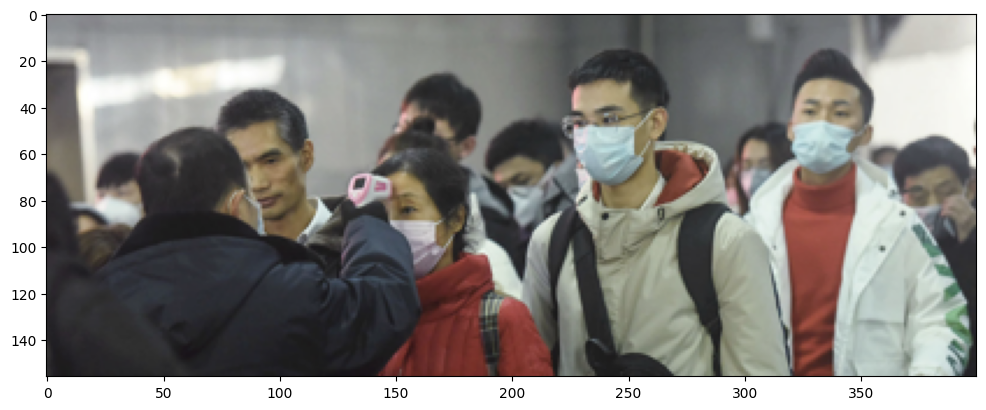

In [4]:
# extract faces from an image and draw rectangles to mark them
# getting the test image path
base_dir = os.path.dirname(os.path.abspath('__file__')) # Get the parent directory of the notebook
image_path = os.path.join(base_dir, 'datasets', 'FMD-SD', 'Face Mask Detection', 'images', 'maksssksksss1.png') # Specify the relative path to the image file

# reading and preprocessing the image
img = cv2.imread(image_path) # Read the image using cv2.imread()
img = cv2.cvtColor(img, cv2.IMREAD_GRAYSCALE) # coloring the image

# detecting the faces in the image using face_model
faces = face_model.detectMultiScale(img, scaleFactor=1.05, minNeighbors=5, minSize=(30,30)) #returns a list of (x,y,w,h) tuples

out_img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR) #colored output image

#plotting the rectangles on the faces from the face_model
for (x,y,w,h) in faces:
    cv2.rectangle(out_img,(x,y),(x+w,y+h),(0,0,255),1)

# show the plot on an image
plt.figure(figsize=(12,12))
plt.imshow(out_img)


Testing Social Distancing Violations

In [5]:
MIN_DISTANCE = 130

if len(faces)>=2:
    label = [0 for i in range(len(faces))]
    for i in range(len(faces)-1):
        for j in range(i+1, len(faces)):
            dist = distance.euclidean(faces[i][:2],faces[j][:2])
            if dist<MIN_DISTANCE:
                label[i] = 1
                label[j] = 1
    new_img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR) #colored output image
    for i in range(len(faces)):
        (x,y,w,h) = faces[i]
        if label[i]==1:
            cv2.rectangle(new_img,(x,y),(x+w,y+h),(255,0,0),1)
        else:
            cv2.rectangle(new_img,(x,y),(x+w,y+h),(0,255,0),1)
    plt.figure(figsize=(10,10))
    plt.imshow(new_img)
            
else:
    print("No. of faces detected is less than 2")

No. of faces detected is less than 2


# Face Mask Detector

Load the images into image arrays

In [10]:
# load the images into image arrays
data = []
labels = []

# getting the path of the cmfd (only the first 1000 images)
base_dir = os.path.dirname(os.path.abspath('__file__')) # Get the parent directory of the notebook
dir_path = os.path.join(base_dir, 'datasets', 'MFN', 'CMFD') # Specify the relative path to the cmfd folder

# loading the cmfd images into data and labels
for img in os.listdir(dir_path):
    img_path = os.path.join(dir_path,img)               #obtain the image path
    image = load_img(img_path, target_size=(224,224))   #load the image and compress it to 224 x 224 to improve speed
    image = img_to_array(image)                         #convert the image to an array
    image = preprocess_input(image)                     #ensure that the image is transformed for the model

    data.append(image)                                  #store the image as an array in data
    labels.append(0)                                    #images are labelled 0 for "CMFD" or "With Mask"

print(len(data))

10672


In [11]:
# getting the path of the imfd (only the first 1000 images)
base_dir = os.path.dirname(os.path.abspath('__file__')) # Get the parent directory of the notebook
dir_path = os.path.join(base_dir, 'datasets', 'MFN', 'IMFD') # Specify the relative path to the imfd folder

# loading the imfd images into data and labels
label = ""

for img in os.listdir(dir_path):
    # assigning the label for each image
    if "Nose" not in img and "Mouth" not in img:
        label=3                                         #label 3 for "IMFD3" or "Uncovered Nose and Mouth"
    elif "Chin" not in img:
        label=1                                         #label 1 for "IMFD1" or "Uncovered Chin"
    elif "Nose" not in img:
        label=2                                         #label 2 for "IMFD2" or "Uncovered Nose"
    img_path = os.path.join(dir_path,img)               #obtain the image path
    image = load_img(img_path, target_size=(224,224))   #load the image and compress it to 224 x 224 to improve speed
    image = img_to_array(image)                         #convert the image to an array
    image = preprocess_input(image)                     #ensure that the image is transformed for the model

    data.append(image)                                  #store the image as an array in data
    labels.append(label)                                #store thelabel obtained

print(len(data))

33602


In [12]:
# getting the path of the NM 
base_dir = os.path.dirname(os.path.abspath('__file__'))                     # Get the parent directory of the notebook
dir_path = os.path.join(base_dir, 'datasets', 'MFN', 'NM')       # Specify the relative path to the NM folder

# loading the cmfd images into data and labels
for img in os.listdir(dir_path):
    img_path = os.path.join(dir_path,img)               #obtain the image path
    image = load_img(img_path, target_size=(224,224))   #load the image and compress it to 224 x 224 to improve speed
    image = img_to_array(image)                         #convert the image to an array
    image = preprocess_input(image)                     #ensure that the image is transformed for the model
    data.append(image)                                  #store the image as an array in data
    labels.append(4)                                    #images are labelled 0 for "NM" or "No Mask"

print(len(data))


45552


Perform one-hot encoding on the labels

In [13]:
# convert labels to arrays
# for instance, 0 = [1, 0, 0, 0], 1 = [0, 1, 0, 0] and so on
 
labels = to_categorical(labels)
# print(labels)

In [14]:
# convert data and labels to NumPy arrays to ensure that elements are represented as 32-bit floating point numbers

data=np.array(data, dtype="float32")
labels=np.array(labels)

In [16]:
print(data.shape)

(45552, 224, 224, 3)


<a id="3"></a>
## Train Test Split
* We split the data into train and test sets.
* test size is 20%.
* train size is 80%.

In [17]:
data.shape

(45552, 224, 224, 3)

In [18]:
# Split the data and labels into train and test sets
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)

# Check the shapes of the resulting arrays
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

X_train shape: (36441, 224, 224, 3)
X_test shape: (9111, 224, 224, 3)
y_train shape: (36441, 5)
y_test shape: (9111, 5)


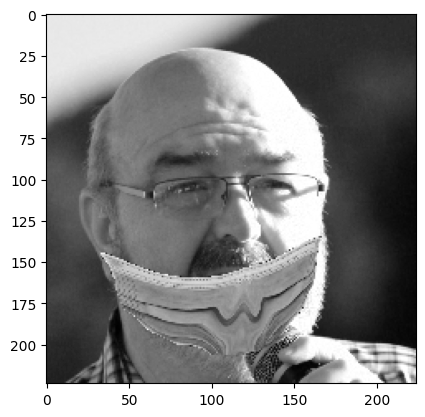

In [20]:
# Show a sample of a train image
plt.imshow(X_train[2][:,:,0],cmap='gray')
plt.show()

<a id="4"></a>
## Convolutional Neural Network 

In [30]:
from tensorflow.keras.layers import Dense
from tensorflow.keras.regularizers import l2


In [31]:
# instantiate values of learning rate, epoch, and batch size
lr = 1e-3 
epoch = 20
bs = 32 

# make the base model using MobileNetV2
base_model = MobileNetV2(
    weights="imagenet",                                         #initialize base_model with pre-trained weights from ImageNet dataset
    include_top=False,                                          #only create the base model as a feature extractor
    input_tensor=Input(shape=(224,224,3))                       #the model expects 224 x 224 images with 3 color channels
)

# constructing the head model

head_model = base_model.output
head_model = AveragePooling2D(pool_size=(7, 7))(head_model)
head_model = Flatten(name="flatten")(head_model)
# Added L2 regularization and increased the number of neurons
head_model = Dense(256, activation="relu", kernel_regularizer=l2(0.01))(head_model)  
head_model = Dropout(0.5)(head_model)
# Another dense layer
head_model = Dense(128, activation="relu", kernel_regularizer=l2(0.01))(head_model)
head_model = Dropout(0.5)(head_model)
# Output layer
head_model = Dense(5, activation="softmax")(head_model)


# head_model = base_model.output                                  #aligns head_model to the output of the base_model
# head_model = AveragePooling2D(pool_size=(7,7))(head_model)      #perform spatial pooling and reduce spatial dimensions of the extracted features with a 7x7 pooling window size
# head_model = Flatten(name="flatten")(head_model)                #convert the output to a 1d vector
# head_model = Dense(128, activation="relu")(head_model)          #add a dense layer with 128 units and relu activation to learn non-linear relationships
# head_model = Dropout(0.5)(head_model)                           #prevent overfitting
# head_model = Dense(5, activation="softmax")(head_model)         #convert the output to a probability distribution over the 5 classes (aka the predictions)

In [32]:
#new model with the inputs being the input of base_model and the output being the head_model

model = Model(inputs=base_model.input, outputs=head_model)

In [33]:
#freeze the layers for training 
for layer in base_model.layers:
    layer.trainable = False

In [34]:
#compile the model
opt = Adam(lr=lr, decay=lr/epoch)           #use the Adam optimizer for keras 
model.compile(
    loss="categorical_crossentropy",        #the loss function is the categorical cross-entropy loss bc there are multiple classes
    optimizer=opt,
    metrics=["accuracy"]
)

In [35]:
#augment the images to create more variations for training
aug = ImageDataGenerator(
	rotation_range=20,
	zoom_range=0.15,
	width_shift_range=0.2,
	height_shift_range=0.2,
	shear_range=0.15,
	horizontal_flip=True,
	fill_mode="nearest")

In [36]:
#train the model using a data generator 

history = model.fit_generator(
    aug.flow(X_train,y_train, batch_size=bs),
    epochs = epoch, 
    validation_data = (X_test,y_test), 
    validation_steps=len(X_test) // bs,
    steps_per_epoch=len(X_train) // bs
    )

Epoch 1/20
  27/1138 [..............................] - ETA: 8:58 - loss: 6.2901 - accuracy: 0.6273

ResourceExhaustedError: Graph execution error:

Detected at node 'model_1/block_1_pad/Pad' defined at (most recent call last):
    File "<frozen runpy>", line 198, in _run_module_as_main
    File "<frozen runpy>", line 88, in _run_code
    File "c:\Users\User\Desktop\3BSCS2\cs180\CS180-MaskPatrol\.venv\Lib\site-packages\ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "c:\Users\User\Desktop\3BSCS2\cs180\CS180-MaskPatrol\.venv\Lib\site-packages\traitlets\config\application.py", line 1043, in launch_instance
      app.start()
    File "c:\Users\User\Desktop\3BSCS2\cs180\CS180-MaskPatrol\.venv\Lib\site-packages\ipykernel\kernelapp.py", line 725, in start
      self.io_loop.start()
    File "c:\Users\User\Desktop\3BSCS2\cs180\CS180-MaskPatrol\.venv\Lib\site-packages\tornado\platform\asyncio.py", line 195, in start
      self.asyncio_loop.run_forever()
    File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.11_3.11.1008.0_x64__qbz5n2kfra8p0\Lib\asyncio\base_events.py", line 607, in run_forever
      self._run_once()
    File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.11_3.11.1008.0_x64__qbz5n2kfra8p0\Lib\asyncio\base_events.py", line 1922, in _run_once
      handle._run()
    File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.11_3.11.1008.0_x64__qbz5n2kfra8p0\Lib\asyncio\events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "c:\Users\User\Desktop\3BSCS2\cs180\CS180-MaskPatrol\.venv\Lib\site-packages\ipykernel\kernelbase.py", line 513, in dispatch_queue
      await self.process_one()
    File "c:\Users\User\Desktop\3BSCS2\cs180\CS180-MaskPatrol\.venv\Lib\site-packages\ipykernel\kernelbase.py", line 502, in process_one
      await dispatch(*args)
    File "c:\Users\User\Desktop\3BSCS2\cs180\CS180-MaskPatrol\.venv\Lib\site-packages\ipykernel\kernelbase.py", line 409, in dispatch_shell
      await result
    File "c:\Users\User\Desktop\3BSCS2\cs180\CS180-MaskPatrol\.venv\Lib\site-packages\ipykernel\kernelbase.py", line 729, in execute_request
      reply_content = await reply_content
    File "c:\Users\User\Desktop\3BSCS2\cs180\CS180-MaskPatrol\.venv\Lib\site-packages\ipykernel\ipkernel.py", line 422, in do_execute
      res = shell.run_cell(
    File "c:\Users\User\Desktop\3BSCS2\cs180\CS180-MaskPatrol\.venv\Lib\site-packages\ipykernel\zmqshell.py", line 540, in run_cell
      return super().run_cell(*args, **kwargs)
    File "c:\Users\User\Desktop\3BSCS2\cs180\CS180-MaskPatrol\.venv\Lib\site-packages\IPython\core\interactiveshell.py", line 3009, in run_cell
      result = self._run_cell(
    File "c:\Users\User\Desktop\3BSCS2\cs180\CS180-MaskPatrol\.venv\Lib\site-packages\IPython\core\interactiveshell.py", line 3064, in _run_cell
      result = runner(coro)
    File "c:\Users\User\Desktop\3BSCS2\cs180\CS180-MaskPatrol\.venv\Lib\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "c:\Users\User\Desktop\3BSCS2\cs180\CS180-MaskPatrol\.venv\Lib\site-packages\IPython\core\interactiveshell.py", line 3269, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "c:\Users\User\Desktop\3BSCS2\cs180\CS180-MaskPatrol\.venv\Lib\site-packages\IPython\core\interactiveshell.py", line 3448, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "c:\Users\User\Desktop\3BSCS2\cs180\CS180-MaskPatrol\.venv\Lib\site-packages\IPython\core\interactiveshell.py", line 3508, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\User\AppData\Local\Temp\ipykernel_6544\1233126279.py", line 3, in <module>
      history = model.fit_generator(
    File "c:\Users\User\Desktop\3BSCS2\cs180\CS180-MaskPatrol\.venv\Lib\site-packages\keras\engine\training.py", line 2636, in fit_generator
      return self.fit(
    File "c:\Users\User\Desktop\3BSCS2\cs180\CS180-MaskPatrol\.venv\Lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\User\Desktop\3BSCS2\cs180\CS180-MaskPatrol\.venv\Lib\site-packages\keras\engine\training.py", line 1685, in fit
      tmp_logs = self.train_function(iterator)
    File "c:\Users\User\Desktop\3BSCS2\cs180\CS180-MaskPatrol\.venv\Lib\site-packages\keras\engine\training.py", line 1284, in train_function
      return step_function(self, iterator)
    File "c:\Users\User\Desktop\3BSCS2\cs180\CS180-MaskPatrol\.venv\Lib\site-packages\keras\engine\training.py", line 1268, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\User\Desktop\3BSCS2\cs180\CS180-MaskPatrol\.venv\Lib\site-packages\keras\engine\training.py", line 1249, in run_step
      outputs = model.train_step(data)
    File "c:\Users\User\Desktop\3BSCS2\cs180\CS180-MaskPatrol\.venv\Lib\site-packages\keras\engine\training.py", line 1050, in train_step
      y_pred = self(x, training=True)
    File "c:\Users\User\Desktop\3BSCS2\cs180\CS180-MaskPatrol\.venv\Lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\User\Desktop\3BSCS2\cs180\CS180-MaskPatrol\.venv\Lib\site-packages\keras\engine\training.py", line 558, in __call__
      return super().__call__(*args, **kwargs)
    File "c:\Users\User\Desktop\3BSCS2\cs180\CS180-MaskPatrol\.venv\Lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\User\Desktop\3BSCS2\cs180\CS180-MaskPatrol\.venv\Lib\site-packages\keras\engine\base_layer.py", line 1145, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "c:\Users\User\Desktop\3BSCS2\cs180\CS180-MaskPatrol\.venv\Lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\User\Desktop\3BSCS2\cs180\CS180-MaskPatrol\.venv\Lib\site-packages\keras\engine\functional.py", line 512, in call
      return self._run_internal_graph(inputs, training=training, mask=mask)
    File "c:\Users\User\Desktop\3BSCS2\cs180\CS180-MaskPatrol\.venv\Lib\site-packages\keras\engine\functional.py", line 669, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "c:\Users\User\Desktop\3BSCS2\cs180\CS180-MaskPatrol\.venv\Lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\User\Desktop\3BSCS2\cs180\CS180-MaskPatrol\.venv\Lib\site-packages\keras\engine\base_layer.py", line 1145, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "c:\Users\User\Desktop\3BSCS2\cs180\CS180-MaskPatrol\.venv\Lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\User\Desktop\3BSCS2\cs180\CS180-MaskPatrol\.venv\Lib\site-packages\keras\layers\reshaping\zero_padding2d.py", line 148, in call
      return backend.spatial_2d_padding(
    File "c:\Users\User\Desktop\3BSCS2\cs180\CS180-MaskPatrol\.venv\Lib\site-packages\keras\backend.py", line 4040, in spatial_2d_padding
      return tf.compat.v1.pad(x, pattern)
Node: 'model_1/block_1_pad/Pad'
OOM when allocating tensor with shape[32,113,113,96] and type float on /job:localhost/replica:0/task:0/device:CPU:0 by allocator cpu
	 [[{{node model_1/block_1_pad/Pad}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_train_function_23060]

## Predicting using the Model

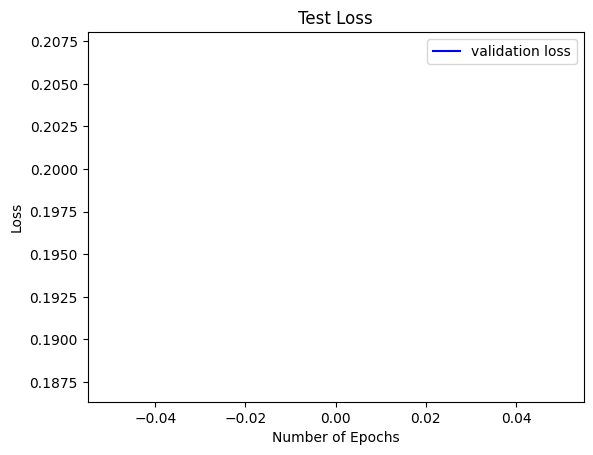

In [ ]:
# Plot the loss and accuracy curves for training and validation 
plt.plot(history.history['val_loss'], color='b', label="validation loss")
plt.title("Test Loss")
plt.xlabel("Number of Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [ ]:
#predict results of the model 
y_pred = model.predict(X_test, batch_size=bs)

109/109 [==============================] - 44s 404ms/step


In [ ]:
y_pred = np.argmax(y_pred, axis=1)
y_test_labels = np.argmax(y_test, axis=1)

AxisError: axis 1 is out of bounds for array of dimension 1

In [ ]:
print(y_pred)
print(y_test_labels)

[4 2 4 ... 0 4 4]
[4 2 4 ... 0 4 4]


In [ ]:
#observe model prediction results
print(classification_report(
    y_test_labels,
    y_pred
))

              precision    recall  f1-score   support

           0       0.99      0.95      0.97      1155
           1       0.71      0.92      0.80       106
           2       0.96      0.99      0.97       985
           3       0.97      0.75      0.85        89
           4       1.00      1.00      1.00      1146

    accuracy                           0.97      3481
   macro avg       0.93      0.92      0.92      3481
weighted avg       0.97      0.97      0.97      3481



In [ ]:
import tensorflow as tf

base_dir = os.path.dirname(os.path.abspath('__file__')) # Get the parent directory of the notebook
model_name = os.path.join(base_dir, 'model', "mask_detection.h5") # Specify the relative path to the image file
face_name = os.path.join(base_dir, 'model', "face_detection.h5") # Specify the relative path to the image file

tf.keras.models.save_model(face_model, face_name)
# tf.keras.models.save_model(model, model_name)

AttributeError: 'cv2.CascadeClassifier' object has no attribute 'outputs'

## Test Model on the Test Data

In [ ]:
# getting the test image path
base_dir = os.path.dirname(os.path.abspath('__file__')) # Get the parent directory of the notebook
image_path = os.path.join(base_dir, 'datasets', 'MaskedFace-Net', 'CMFD', '00000') # Specify the relative path to the image file

sample_mask_img = cv2.imread(image_path)
sample_mask_img = cv2.resize(sample_mask_img,(224,224))
plt.imshow(sample_mask_img)
sample_mask_img = np.reshape(sample_mask_img,[1,224,224,3])
sample_mask_img = sample_mask_img

NameError: name 'os' is not defined

In [ ]:
mask_label = {0:'MASK', 1:'UNCOVERED CHIN', 2:'UNCOVERED NOSE', 3:'UNCOVERED NOSE AND MOUTH', 4:"NO MASK"}
dist_label = {0:(0,255,0),1:(255,0,0)}

In [1]:
# extract faces from an image and draw rectangles to mark them
# getting the test image path
base_dir = os.path.dirname(os.path.abspath('__file__')) # Get the parent directory of the notebook
image_path = os.path.join(base_dir, 'datasets', 'FMD-SD', 'Face Mask Detection', 'images', 'maksssksksss244.png') # Specify the relative path to the image file

# reading and preprocessing the image
img = cv2.imread(image_path) # Read the image using cv2.imread()
img = cv2.cvtColor(img, cv2.IMREAD_GRAYSCALE) # coloring the image

# detecting the faces in the image using face_model
faces = face_model.detectMultiScale(img, scaleFactor=1.1, minNeighbors=4) #returns a list of (x,y,w,h) tuples

out_img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR) #colored output image

#plotting the rectangles on the faces from the face_model
for (x,y,w,h) in faces:
    cv2.rectangle(out_img,(x,y),(x+w,y+h),(0,0,255),1)

if len(faces)>=2:
    label = [0 for i in range(len(faces))]
    for i in range(len(faces)-1):
        for j in range(i+1, len(faces)):
            dist = distance.euclidean(faces[i][:2],faces[j][:2])
            if dist<MIN_DISTANCE:
                label[i] = 1
                label[j] = 1
    new_img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR) #colored output image
    for i in range(len(faces)):
        (x,y,w,h) = faces[i]
        crop = new_img[y:y+h,x:x+w]
        crop = cv2.resize(crop,(224,224))
        crop = np.reshape(crop,[1,224,224,3])
        print(crop)
        mask_result = model.predict(crop, batch_size=bs)
        cv2.putText(new_img,mask_label[mask_result.argmax()],(x, y-10),cv2.FONT_HERSHEY_SIMPLEX,0.5,dist_label[label[i]],2)
        cv2.rectangle(new_img,(x,y),(x+w,y+h),dist_label[label[i]],1)
    plt.figure(figsize=(10,10))
    plt.imshow(new_img)
            
else:
    print("No. of faces detected is less than 2")

NameError: name 'os' is not defined